# Set-Up and Imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plotting settings:

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300
# Plot theme:
sns.set_theme(style='darkgrid')

Save directory for figures:

In [3]:
fig_save_dir = './figs/joint'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

Random seed:

In [4]:
seed = 42

Let's load our surrogate model from the last chapter:

In [5]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')

For convenience, we'll wrap this model for easier interfacing with other bits of software:

In [6]:
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)

Sampling function:

In [7]:
num_samples = 10000
def draw_joint_samples(joint, d_vals, num_samples, seed):
    joint_samples = {}
    for d in d_vals:
        joint_samples[f'd = {d}'] = joint.sample(d, num_samples, rng=np.random.default_rng(seed))
    return joint_samples

# Some Initial Samples

As an initial 'sanity check' on our model, let's first draw some $(\theta, y)$ samples from the joint distribution for different $d$ values for given noise and covariance:

In [8]:
noise_cov = 0.001*jnp.identity(1)
prior_cov = 0.005*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

First, let's see what the prior looks like by itself:

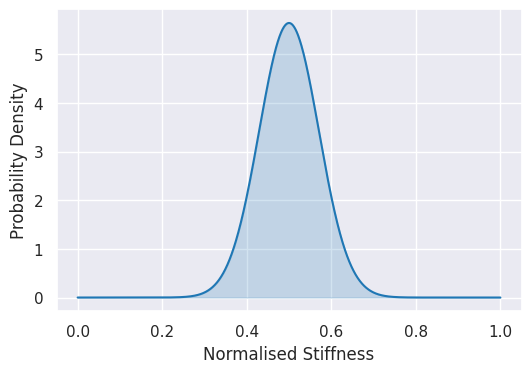

In [9]:
theta = jnp.linspace(0,1,1000).reshape(-1,1)
prior_pdf = jnp.exp(prior.logpdf(theta)['logpdf'])
fig = plotting_helpers.plot_distributions({'Prior': prior_pdf}, theta, xlabel='Normalised Stiffness', show_labels=False)
plt.savefig(os.path.join(fig_save_dir, 'original_prior.png'), dpi=mpl_save_dpi)

Next, let's see the likelihood plotted for some different d values:

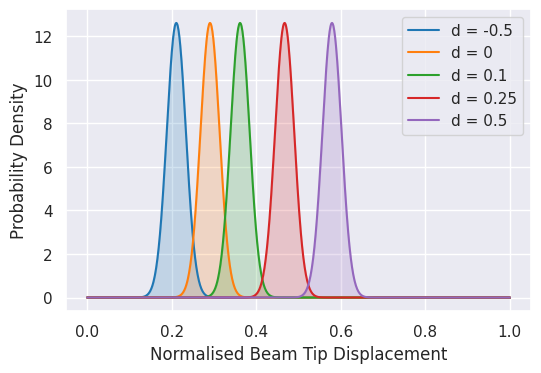

In [10]:
y = jnp.linspace(-0.4,1,1000).reshape(-1,1)
d_vals = [-0.5, 0, 0.1, 0.25, 0.5]
likelihood_pdf = {}
for d in d_vals:
    likelihood_pdf[f'd = {d}'] = jnp.exp(likelihood.logpdf(y, prior_mean, d)['logpdf'])
fig = plotting_helpers.plot_distributions(likelihood_pdf, theta, xlabel='Normalised Beam Tip Displacement')
plt.savefig(os.path.join(fig_save_dir, 'like_effect_of_d_1.png'), dpi=mpl_save_dpi)

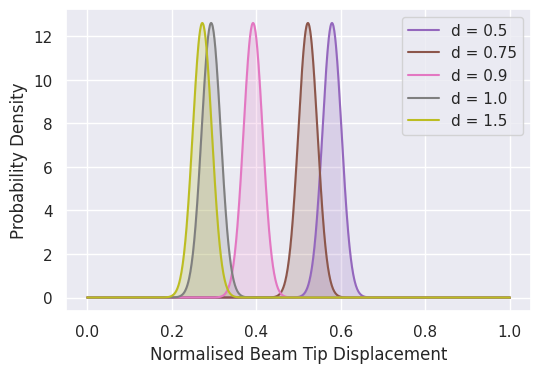

In [12]:
y = jnp.linspace(-0.4,1,1000).reshape(-1,1)
d_vals = [0.5, 0.75, 0.9, 1.0, 1.5]
likelihood_pdf = {}
for d in d_vals:
    likelihood_pdf[f'd = {d}'] = jnp.exp(likelihood.logpdf(y, prior_mean, d)['logpdf'])
fig = plotting_helpers.plot_distributions(likelihood_pdf, theta, xlabel='Normalised Beam Tip Displacement', color_start=4)
plt.savefig(os.path.join(fig_save_dir, 'like_effect_of_d_2.png'), dpi=mpl_save_dpi)

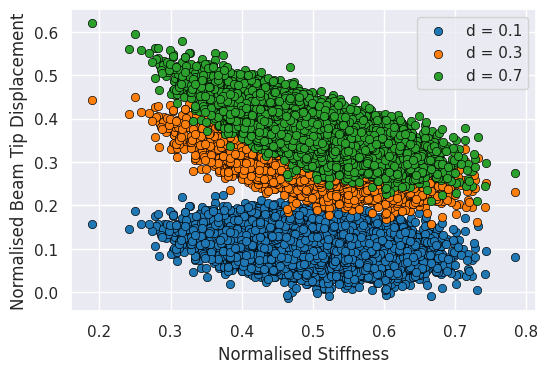

In [13]:
d_vals = [0.1, 0.3, 0.7] #np.linspace(0.1, 0.9, 4)
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples)
plt.savefig(os.path.join(fig_save_dir, 'joint_effect_of_d_1.png'), dpi=mpl_save_dpi)

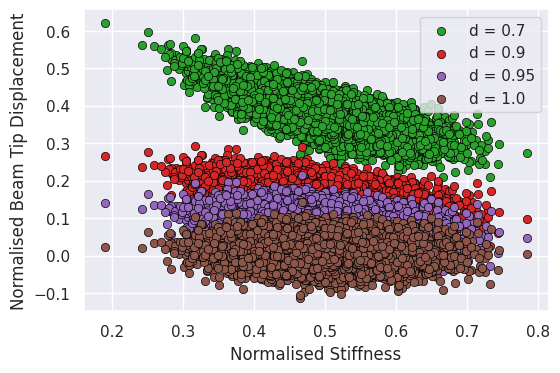

In [14]:
d_vals = [0.7, 0.9, 0.95, 1.0]
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples, start_colour=2)
plt.savefig(os.path.join(fig_save_dir, 'joint_effect_of_d_2.png'), dpi=mpl_save_dpi)

# Effect of Noise

Let's see how noise affects the joint distribution

In [15]:
noise_cov = 0.01*jnp.identity(1)
prior_cov = 0.005*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

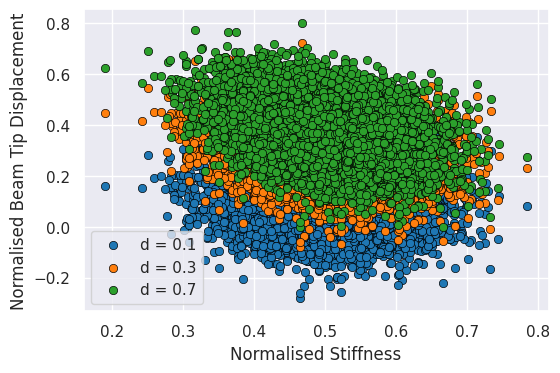

In [16]:
d_vals = [0.1, 0.3, 0.7] 
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples)
plt.savefig(os.path.join(fig_save_dir, 'noise_effect_1.png'), dpi=mpl_save_dpi)

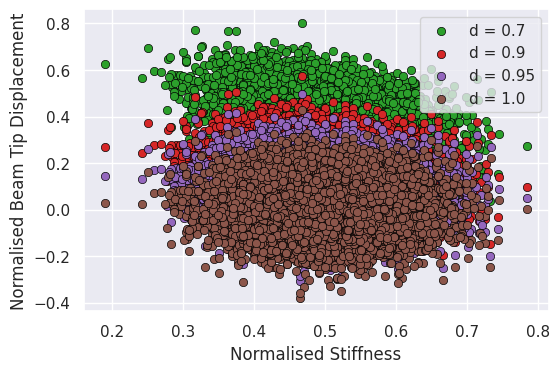

In [17]:
d_vals = [0.7, 0.9, 0.95, 1.0]
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples, start_colour=2)
plt.savefig(os.path.join(fig_save_dir, 'noise_effect_2.png'), dpi=mpl_save_dpi)

# Effect of Prior

Interesting things were happening at low theta values - let's place our theta there

In [18]:
noise_cov = 0.001*jnp.identity(1)
prior_cov = 0.002*jnp.identity(1)
prior_mean = 0.15*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

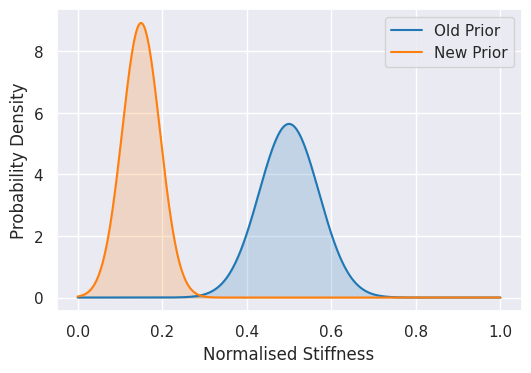

In [19]:
theta = jnp.linspace(0,1,1000).reshape(-1,1)
new_prior_pdf = jnp.exp(prior.logpdf(theta)['logpdf'])
fig = plotting_helpers.plot_distributions({'Old Prior': prior_pdf, 'New Prior': new_prior_pdf}, theta, xlabel='Normalised Stiffness')
plt.savefig(os.path.join(fig_save_dir, 'new_prior.png'), dpi=mpl_save_dpi)

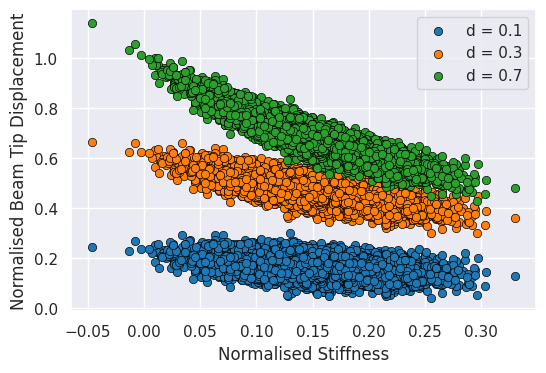

In [20]:
d_vals = [0.1, 0.3, 0.7] #np.linspace(0.1, 0.9, 4)
num_samples = 10000
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples)
plt.savefig(os.path.join(fig_save_dir, 'prior_effect_1.png'), dpi=mpl_save_dpi)

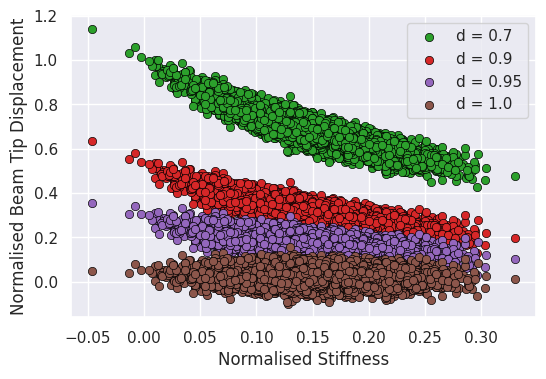

In [21]:
d_vals = [0.7, 0.9, 0.95, 1.0]
num_samples = 10000
joint_samples = draw_joint_samples(joint, d_vals, num_samples, seed)
fig = plotting_helpers.plot_joint_samples(joint_samples, start_colour=2)
plt.savefig(os.path.join(fig_save_dir, 'prior_effect_2.png'), dpi=mpl_save_dpi)